<a href="https://colab.research.google.com/github/kuds/rl-atari-tennis/blob/main/%5BAtari%20Tennis%5D%20Single-Agent%20Reinforcement%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Atari Tennis] Single-Agent Reinforcement Learning

In [1]:
!pip install swig

In [2]:
!pip install gymnasium gymnasium[atari] autorom

In [3]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.10/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


In [4]:
!pip install stable-baselines3

In [5]:
import platform
import torch
import numpy
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common.vec_env import VecTransposeImage
import matplotlib.pyplot
import matplotlib
import os
import gymnasium
from importlib.metadata import version
import time

In [6]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")

Python Version: 3.10.12
Torch Version: 2.4.0+cu121
Is Cuda Available: True
Cuda Version: 12.1
Gymnasium Version: 0.29.1
Numpy Version: 1.26.4
Stable Baselines3 Version: 2.3.2


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
env_str = "ALE/Tennis-v5"
log_dir = "./logs/{}".format(env_str)

In [8]:
env = make_atari_env(env_str, n_envs=1, seed=0)
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  (84, 84, 1)
Actions Space:  Discrete(18)


In [9]:
# Create the Training Atari Tennis environment with appropriate wrappers
env = make_atari_env(env_str, n_envs=1, seed=0)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Create the Evaluation Atari Tennis environment with appropriate wrappers
env_val = make_atari_env(env_str, n_envs=1, seed=0)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Create Evaluation Callback
# eval_freq - can cause learning instability if set to low
eval_callback = EvalCallback(env,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=20000,
                             render=False,
                             n_eval_episodes=5)

# Initialize PPO
# ent_coef - encourages exploration of other actins
model = PPO("CnnPolicy",
            env,
            verbose=0,
            ent_coef=0.005)

# Train the model
model.learn(total_timesteps=500_000,
            progress_bar=True,
            callback=eval_callback)

# Save the trained model
model.save("ppo_tennis")

env.close()
env_val.close()

# # To visualize the agent's performance, create an unwrapped environment
# test_env = gymnasium.make("ALE/Tennis-v5")
# test_env = gymnasium.wrappers.AtariPreprocessing(test_env)
# test_env = gymnasium.wrappers.FrameStack(test_env, 4)

# obs = test_env.reset()
# while True:
#     # Preprocess observation for the model
#     obs_input = numpy.expand_dims(obs, axis=0)
#     # Get action from the trained model
#     action, _ = model.predict(obs_input, deterministic=True)
#     # Step the environment
#     obs, reward, done, info = test_env.step(action)
#     # Render the environment
#     test_env.render()
#     if done:
#         obs = test_env.reset()

Output()

Eval num_timesteps=20000, episode_reward=-1.40 +/- 0.80

Episode length: 27000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=40000, episode_reward=-1.00 +/- 0.00

Episode length: 27000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=60000, episode_reward=-21.40 +/- 5.20

Episode length: 6628.20 +/- 10185.91

Eval num_timesteps=80000, episode_reward=-19.40 +/- 9.20

Episode length: 6630.20 +/- 10184.91

Eval num_timesteps=100000, episode_reward=-22.60 +/- 2.80

Episode length: 6738.40 +/- 10130.92

In [18]:
# Create Evaluation environment
env_val = make_atari_env(env_str, n_envs=1, seed=0)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env_val)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=5)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Lunar Lander
rec_val = VecVideoRecorder(env_val, "./videos/",
                       video_length=5000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_atari_tennis_lander_ppo")

obs = rec_val.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = rec_val.step(action)
    rec_val.render()
    if dones:
      break

env_val.close()
rec_val.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Model - Mean reward: -1.00 +/- 0.00


/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Saving video to /content/videos/best_model_atari_tennis_lander_ppo-step-0-to-step-5000.mp4
Moviepy - Building video /content/videos/best_model_atari_tennis_lander_ppo-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/videos/best_model_atari_tennis_lander_ppo-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_atari_tennis_lander_ppo-step-0-to-step-5000.mp4


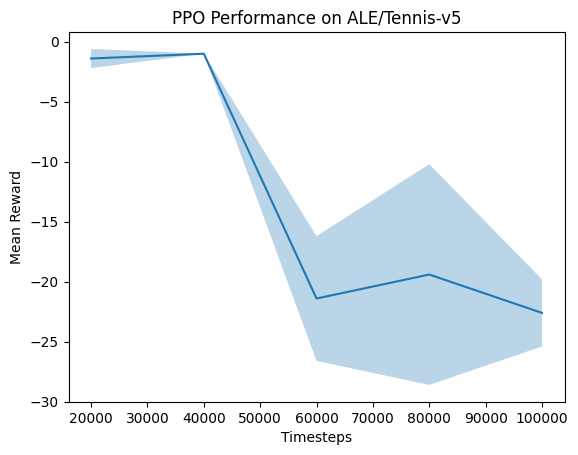

In [13]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"PPO Performance on {env_str}")
matplotlib.pyplot.show()